**Masking & Regional Stats**
# Setting
## Loading libraries

In [1]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import os
#intake-esm to load the Pangeo CMIP6 cloud collection
import intake
import regionmask
import cartopy.crs as ccrs

## Accessing models/model ensembles through Pangeo

In [2]:
# copied from Julius's notebook
# use intake-esm to load the Pangeo CMIP6 cloud collection
import intake
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

In [3]:
col.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,hfls,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,hus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,zg,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,prw,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
...,...,...,...,...,...,...,...,...,...,...,...
511420,CMIP,CMCC,CMCC-CM2-HR4,abrupt-4xCO2,r1i1p1f1,Amon,sfcWind,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-HR4/abrupt...,NaN,20210624
511421,CMIP,CMCC,CMCC-CM2-HR4,abrupt-4xCO2,r1i1p1f1,Amon,uas,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-HR4/abrupt...,NaN,20210624
511422,CMIP,CMCC,CMCC-CM2-HR4,abrupt-4xCO2,r1i1p1f1,day,rlut,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-HR4/abrupt...,NaN,20210624
511423,ScenarioMIP,AS-RCEC,TaiESM1,ssp585,r1i1p1f1,day,tasmin,gn,gs://cmip6/CMIP6/ScenarioMIP/AS-RCEC/TaiESM1/s...,NaN,20210721


In [4]:
# show all of the models available in col
np.sort(col.df['source_id'].unique())

array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR',
       'BCC-CSM2-HR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0',
       'CAS-ESM2-0', 'CESM1-1-CAM5-CMIP5', 'CESM1-WACCM-SC', 'CESM2',
       'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CIESM',
       'CMCC-CM2-HR4', 'CMCC-CM2-SR5', 'CMCC-CM2-VHR4', 'CMCC-ESM2',
       'CNRM-CM6-1', 'CNRM-CM6-1-HR', 'CNRM-ESM2-1', 'CanESM5',
       'CanESM5-CanOE', 'E3SM-1-0', 'E3SM-1-1', 'E3SM-1-1-ECA',
       'EC-Earth3', 'EC-Earth3-AerChem', 'EC-Earth3-CC', 'EC-Earth3-LR',
       'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'EC-Earth3P', 'EC-Earth3P-HR',
       'EC-Earth3P-VHR', 'ECMWF-IFS-HR', 'ECMWF-IFS-LR', 'FGOALS-f3-H',
       'FGOALS-f3-L', 'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-AM4', 'GFDL-CM4',
       'GFDL-CM4C192', 'GFDL-ESM2M', 'GFDL-ESM4', 'GFDL-OM4p5B',
       'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'GISS-E2-2-G',
       'HadGEM3-GC31-HM', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-LM',
       'HadGEM3-GC31-MM', 'IITM-ESM', 'I

# Only one model -- Sea surface temperature data from ACCESS-ESM 1.5 model
We first take a closer look into one model from ACCESS-ESM 1.5 model ensemble

## Accessing sea surface temperature data using ACCESS-ESM 1.5 model (only one ensemble)

In [5]:
# create a subcollection with certain search criteria
cat = col.search(
    #Set the variables that you want to search for
    variable_id = 'tos',
    source_id = 'ACCESS-ESM1-5',
    #Eperiments of interest
    experiment_id = ['historical', 'ssp585'],
    #Native grid
    grid_label = 'gn',
    #Monthly ocean data
    table_id = 'Omon',
    member_id = 'r22i1p1f1'
)


# load all datasets into a python dictionary
ddict = cat.to_dataset_dict(
    zarr_kwargs={'consolidated':True, 'use_cftime':True}, # recommended for faster reading and better time handling
    storage_options={'token': 'anon'}, # needed to access the public CMIP6 data on google
    aggregate=False
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [6]:
# checking what models are available in 'ACCESS-ESM1-5' ensemble
ddict

{'CMIP.CSIRO.ACCESS-ESM1-5.historical.r22i1p1f1.Omon.tos.gn.gs://cmip6/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r22i1p1f1/Omon/tos/gn/v20200922/.nan.20200922': <xarray.Dataset>
 Dimensions:             (i: 360, j: 300, time: 1980, bnds: 2, vertices: 4)
 Coordinates:
   * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
   * j                   (j) int32 0 1 2 3 4 5 6 ... 293 294 295 296 297 298 299
     latitude            (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
     longitude           (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
   * time                (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:0...
     time_bnds           (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
 Dimensions without coordinates: bnds, vertices
 Data variables:
     tos                 (time, j, i) float32 dask.array<chunksize=(201, 300, 360), meta=np.ndarray>
     vertices_latitude   (j, i, vertices) float6

In [49]:
SST = ddict['CMIP.CSIRO.ACCESS-ESM1-5.historical.r22i1p1f1.Omon.tos.gn.gs://cmip6/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r22i1p1f1/Omon/tos/gn/v20200922/.nan.20200922']
SST

<xarray.Dataset>
Dimensions:             (i: 360, j: 300, time: 1980, bnds: 2, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 293 294 295 296 297 298 299
    latitude            (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
  * time                (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    tos                 (time, j, i) float32 dask.array<chunksize=(201, 300, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(300, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(300, 360, 4), meta=np.ndarray>
Attributes: (12/52)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   175317.0
    cmor_version:            3.4.0
    ...                      ...
    variable_id:             tos
    variant_label:           r22i1p1f1
    version:                 v20200922
    version_id:              v20200922
    intake_esm_varname:      None
    intake_esm_dataset_key:  CMIP.CSIRO.ACCESS-ESM1-5.historical.r22i1p1f1.Om...

## Defining function to correct coordinates

In [50]:
def corrcoords(array):
    '''
    Inputs:
    array - Data array on which longitude corrections will be applied.
    
    Output:
    Data array with corrected longitude values.
    '''
    
    # Making a deep copy of original longitude values in the array being corrected
    lon = array['longitude'][0].values
    
    # Values changed from 0-360 to between -180 and +180.
    lon[np.where(lon > 180)] = lon[np.where(lon >180)]-360
    
    # Assigning corrected longitudes and latitude values to i and j, which are index based
    array.coords['i'] = lon
    array.coords['j'] = array['latitude'][:,0].values
    
    # Removing latitude and longitude dimensions and renaming i and j dimensions
    array = array.drop(('latitude', 'longitude'))
    array = array.rename(({'i':'longitude', 'j':'latitude'}))
    
    # Longitude values must be sorted from smallest to largest prior to plotting
    array = array.sortby(array.longitude)
    
    return array

In [51]:
# We are just interested in latitude between -30 to -90
SST_SO = corrcoords(SST.tos).sel(latitude = slice(-90, -30))

/srv/conda/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


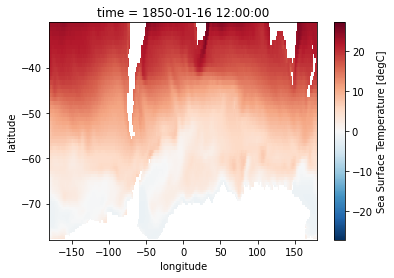

In [52]:
SST_SO[0].plot()

## Loading shapefile with regions of interest
Using `geopandas` to read shapefile and `regionmask` to create the mask to be applied to the dataset.  
For this notebook, a subset of the MEASO regions [https://soki.aq/pages/viewpage.action?pageId=61210912], use to carry out ecosystem assessments in the Southern Ocean, will be used.

In [53]:
measo = geopandas.read_file('../shapefiles/measo_wgs84.shp')

#West Pacific regions are removed because they have duplicate names as the boundaries straddle the -180/180 boundary
measo_sub = measo.query("sector != 'West Pacific'")

#Plotting subset for reference
measo_sub.plot(column = 'name', legend = True)

DriverError: ../shapefiles/measo_wgs84.shp: No such file or directory

### Creating an xarray mask of the MEASO regions

In [54]:
#Defining the extent of the shapefile in lat and lon
longitude = SST_SO['longitude'].values
latitude = SST_SO['latitude'].values

#Creating a 3D mask, which includes regions as a dimension
mask3D = regionmask.mask_3D_geopandas(measo_sub, longitude, latitude)
mask3D

NameError: name 'measo_sub' is not defined

# Accessing multiple ensembles

## Selecting data  (Creating a subcollection)
Choosing datasets by experiment_id & variable_id
(e.g. when you want the datasets with experiment_id == 'ssp585' & 'historical' and variable_id == 'no3os' & 'tos')

In [7]:
## original code, adapted into the model_list function in the following cell

## all source_id with experiment_id == 'ssp585' or 'historical'
#elist1 = col.df[col.df.experiment_id == 'ssp585'].source_id.unique()
#elist2 = col.df[col.df.experiment_id == 'historical'].source_id.unique()
#elist = set(elist1).intersection(elist2)

## all source_id with variable_id == 'no3os' or 'tos'
#vlist1 = col.df[col.df.variable_id == 'no3os'].source_id.unique()
#vlist2 = col.df[col.df.variable_id == 'tos'].source_id.unique()
#vlist = set(vlist1).intersection(vlist2)

#model_list = set(elist).intersection(vlist)
#model_list

Defining a function to select data ensembles based on experiment_id & variable_id

In [8]:
# function to select data ensemble
def model_list(experiment_id1,experiment_id2,variable_id1,variable_id2):
    list1 = col.df[col.df.experiment_id == experiment_id1].source_id.unique()
    list2 = col.df[col.df.experiment_id == experiment_id2].source_id.unique()

    elist = np.intersect1d(list1,list2)

    # all source_id with variable_id == 'no3os' or 'tos'
    vlist1 = col.df[col.df.variable_id == variable_id1].source_id.unique()
    vlist2 = col.df[col.df.variable_id == variable_id2].source_id.unique()

    vlist = np.intersect1d(vlist1,vlist2)

    model = np.intersect1d(vlist,elist)
    return model

e.g. datasets with experiment_id == 'ssp585' & 'historical' and variable_id == 'no3os' & 'tos'

In [9]:
# adapted from from Julius's notebook
# create a subcollection with certain search criteria

models = model_list('historical','ssp585','tos','no3os')

query = dict(
    variable_id = ["tos", "no3os"], # variables of interest
    experiment_id = ["historical", "ssp585"], # experiments of interest
    table_id = ["Omon"], # monthly ocean data
    source_id = models, # selected ensembles
    grid_label = 'gn' # model's native grid
)

cat = col.search(require_all_on=["source_id"], **query)
cat = cat.search(member_id = ['r2i1p1f1', 'r3i1p1f1', 'r2i1p2f1', 'r3i1p2f1']) # to avoid runtime error, reducing # of model members

Checking whether all datasets have variable_id & experiment_id that we want

In [10]:
cat.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id", "member_id"]
].nunique()

,experiment_id,variable_id,table_id,member_id
source_id,,,,
ACCESS-ESM1-5,2,2,1,2
CESM2,1,2,1,2
CESM2-WACCM,2,2,1,2
CanESM5,2,2,1,4
CanESM5-CanOE,2,2,1,2
IPSL-CM6A-LR,2,2,1,2
MPI-ESM1-2-HR,2,2,1,2
MPI-ESM1-2-LR,2,2,1,2
NorESM2-LM,1,2,1,2


Now load all datasets into a python dictionary

In [11]:
# load all datasets into a python dictionary
ddict = cat.to_dataset_dict(
    zarr_kwargs={'consolidated':True, 'use_cftime':True}, # recommended for faster reading and better time handling
    storage_options={'token': 'anon'}, # needed to access the public CMIP6 data on google
    aggregate=False,
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


### Taking a look into the subcollection

In [12]:
# to figure out the xarray dataset (this code will give a long list in ddict)
# ddict

Looking into the subselected dataset

In [13]:
# first dataset on ddict list
ds_a = ddict['ScenarioMIP.CCCma.CanESM5.ssp585.r3i1p2f1.Omon.no3os.gn.gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp585/r3i1p2f1/Omon/no3os/gn/v20190429/.nan.20190429']
ds_a

<xarray.Dataset>
Dimensions:             (i: 360, j: 291, time: 1032, bnds: 2, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 284 285 286 287 288 289 290
    latitude            (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * time                (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    no3os               (time, j, i) float32 dask.array<chunksize=(211, 291, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
Attributes: (12/58)
    CCCma_model_hash:            Unknown
    CCCma_parent_runid:          p2-his03
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 p2-s8503
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   2015:01:01:00
    ...                          ...
    variant_label:               r3i1p2f1
    version:                     v20190429
    netcdf_tracking_ids:         hdl:21.14100/c22f74bf-a623-4a63-bf4d-341d4c7...
    version_id:                  v20190429
    intake_esm_varname:          None
    intake_esm_dataset_key:      ScenarioMIP.CCCma.CanESM5.ssp585.r3i1p2f1.Om...

In [14]:
# second dataset on ddict list
ds_b = ddict['CMIP.CCCma.CanESM5.historical.r2i1p2f1.Omon.tos.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical/r2i1p2f1/Omon/tos/gn/v20190429/.nan.20190429']
ds_b

<xarray.Dataset>
Dimensions:             (i: 360, j: 291, time: 1980, bnds: 2, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 284 285 286 287 288 289 290
    latitude            (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * time                (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    tos                 (time, j, i) float32 dask.array<chunksize=(215, 291, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
Attributes: (12/58)
    CCCma_model_hash:            Unknown
    CCCma_parent_runid:          p2-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 p2-his02
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    version:                     v20190429
    status:                      2019-11-11;created;by nhn2@columbia.edu
    netcdf_tracking_ids:         hdl:21.14100/7f75d040-a455-49bd-9e48-f6b012f...
    version_id:                  v20190429
    intake_esm_varname:          None
    intake_esm_dataset_key:      CMIP.CCCma.CanESM5.historical.r2i1p2f1.Omon....

Checking the dimensions

In [15]:
print(ds_a.dims)
print(ds_b.dims)

Frozen({'i': 360, 'j': 291, 'time': 1032, 'bnds': 2, 'vertices': 4})
Frozen({'i': 360, 'j': 291, 'time': 1980, 'bnds': 2, 'vertices': 4})


In [16]:
# copied from Julius's notebook
from cmip6_preprocessing.preprocessing import combined_preprocessing
print(combined_preprocessing(ds_a).dims)
print(combined_preprocessing(ds_b).dims)

Frozen({'time': 1032, 'y': 291, 'x': 360, 'bnds': 2, 'vertex': 4})
Frozen({'time': 1980, 'y': 291, 'x': 360, 'bnds': 2, 'vertex': 4})


## Loading all datasets in the subcollection into a python dictionary

In [17]:
# copied from Julius's notebook
# load all datasets into a python dictionary
ddict = cat.to_dataset_dict(
    zarr_kwargs={'consolidated':True, 'use_cftime':True}, # recommended for faster reading and better time handling
    storage_options={'token': 'anon'}, # needed to access the public CMIP6 data on google
    aggregate=False,
    preprocess=combined_preprocessing, # this applies the preprocessing to all datasets
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


Plotting to visualize some of the model projections

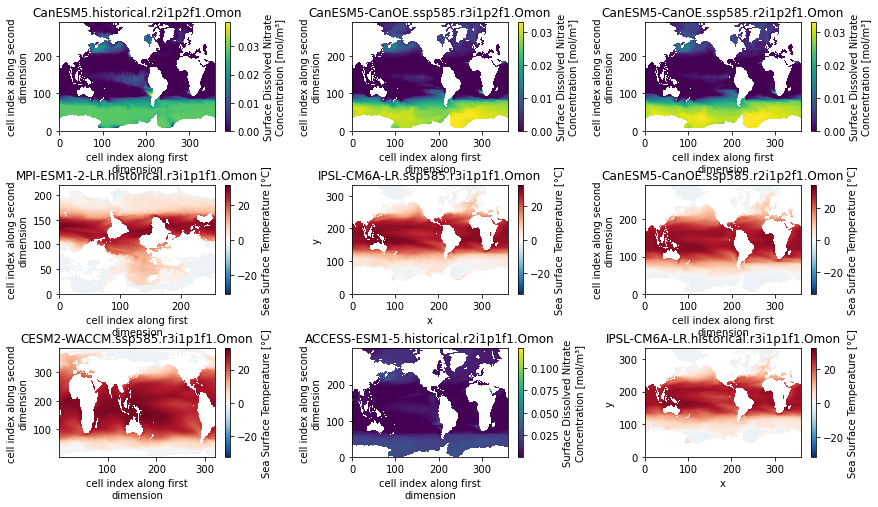

In [18]:
# copied from Julius's notebook
# quick example of how to loop over several models
from cmip6_preprocessing.utils import cmip6_dataset_id
fig, axarr = plt.subplots(ncols=3, nrows=3, figsize=[14,8])
for ax, (name, ds) in zip(axarr.flat, ddict.items()):
    # select the first time step
    ds = ds.isel(time=0)
    # select the datavariable
    da = ds[ds.variable_id]
    # plot
    
    da.plot(ax=ax)
    ax.set_title('.'.join(cmip6_dataset_id(ds).split('.')[2:6]))
    
fig.subplots_adjust(hspace=0.5, wspace=0.5)

## Grouping the dataset (by source_id??)

In [66]:
from cmip6_preprocessing.postprocessing import merge_variables, concat_members, concat_experiments

ddict_combined_a = merge_variables(ddict)

# modified from the original ohw_21_cmip6_pp_tutorial notebook due to experiment_id & variable_id causing errors
def maybe_remove_attrs(ds, attr):
    if attr in ds.attrs.keys():
        del ds.attrs[attr]
    return ds
# remove the `variable_id` attr manually
ddict_combined_aa = {k:maybe_remove_attrs(ds, 'variable_id') for k,ds in ddict_combined_a.items()}
ddict_combined_b = concat_experiments(ddict_combined_aa)
# same thing for experiment_id
ddict_combined_bb = {k:maybe_remove_attrs(ds, 'experiment_id') for k,ds in ddict_combined_b.items()}
ddict_combined = concat_members(ddict_combined_bb)

/srv/conda/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.NCAR.CESM2.historical.r3i1p1f1.Omon.gn.none.no3os failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.NCAR.CESM2.historical.r2i1p1f1.Omon.gn.none.no3os failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['variable_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(
/srv/conda/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['experiment_id', 'variable_id'] not found in any of the dat

Dictionary keys

In [42]:
ddict_combined.keys()

dict_keys(['CanESM5.gn.Omon', 'CanESM5-CanOE.gn.Omon', 'MPI-ESM1-2-LR.gn.Omon', 'IPSL-CM6A-LR.gn.Omon', 'CESM2-WACCM.gn.Omon', 'ACCESS-ESM1-5.gn.Omon', 'MPI-ESM1-2-HR.gn.Omon', 'NorESM2-LM.gn.Omon'])

In [67]:
ddict_combined['CanESM5.gn.Omon']

,Array,Chunk
Bytes,4.70 GiB,83.92 MiB
Shape,"(4, 3012, 291, 360)","(1, 210, 291, 360)"
Count,372 Tasks,76 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,4.70 GiB,85.92 MiB
Shape,"(4, 3012, 291, 360)","(1, 215, 291, 360)"
Count,274 Tasks,60 Chunks
Type,float32,numpy.ndarray


In [44]:
type(ddict_combined['CanESM5.gn.Omon'].tos)

xarray.core.dataarray.DataArray

## Correcting the coordinates

Importing coordinate conversion functions from pyoceans (https://github.com/pyoceans/python-oceans/blob/master/oceans/ocfis.py)

In [68]:
def wrap_lon180(lon):
    lon = np.atleast_1d(lon)
    angles = np.logical_or((lon < -180), (180 < lon))
    lon[angles] = wrap_lon360(lon[angles] + 180) - 180
    return lon


def wrap_lon360(lon):
    lon = np.atleast_1d(lon)
    positive = lon > 0
    lon = lon % 360
    lon[np.logical_and(lon == 0, positive)] = 360
    return lon

Iterating through the entire dictionary

In [69]:
for key in ddict_combined:
    lon = ddict_combined[key]["lon"]
    new_lon = wrap_lon180(ddict_combined[key]["lon"])
    ddict_combined[key]["lon"] = xr.DataArray(new_lon, coords=lon.coords, dims = lon.dims, name = lon.name, attrs = lon.attrs)

In [70]:
lon = ddict_combined['CanESM5.gn.Omon']["lon"]
new_lon = wrap_lon180(ddict_combined['CanESM5.gn.Omon']["lon"])
ddict_combined['CanESM5.gn.Omon']["lon"] = xr.DataArray(new_lon, coords=lon.coords, dims = lon.dims, name = lon.name, attrs = lon.attrs)

In [71]:
ddict_combined['CanESM5.gn.Omon']["lon"].max(), ddict_combined['CanESM5.gn.Omon']["lon"].min()

(<xarray.DataArray 'lon' ()>
 array(179.99031067),
 <xarray.DataArray 'lon' ()>
 array(-179.99415588))

In [72]:
ddict_combined['CanESM5.gn.Omon']

,Array,Chunk
Bytes,4.70 GiB,83.92 MiB
Shape,"(4, 3012, 291, 360)","(1, 210, 291, 360)"
Count,372 Tasks,76 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,4.70 GiB,85.92 MiB
Shape,"(4, 3012, 291, 360)","(1, 215, 291, 360)"
Count,274 Tasks,60 Chunks
Type,float32,numpy.ndarray


## Slicing the grouped dataset (subcollection) into a smaller region by the coordinates

In [86]:
# choose latitude & longitude of your interest
min_lat = -60
max_lat = -30
min_lon = -60
max_lon = 120

In [102]:
# define a function slicing ddict_combined by latitudes & longitudes
def choose_region(min_latitude, max_latitude, min_longitude, max_longitude):
    for key in ddict_combined:
        ddict_combined[key] = ddict_combined[key].where(ddict_combined[key]["lat"] > min_latitude, drop=True)
        ddict_combined[key] = ddict_combined[key].where(ddict_combined[key]["lat"] < max_latitude, drop=True)
        ddict_combined[key] = ddict_combined[key].where(ddict_combined[key]["lon"] > min_longitude, drop=True)
        ddict_combined[key] = ddict_combined[key].where(ddict_combined[key]["lon"] < max_longitude, drop=True)

In [103]:
choose_region(min_lat, max_lat, min_lon, max_lon)

In [104]:
# checking for latitude
ddict_combined['CanESM5.gn.Omon']["lat"].max(), ddict_combined['CanESM5.gn.Omon']["lat"].min()

(<xarray.DataArray 'lat' ()>
 array(-30.4554081),
 <xarray.DataArray 'lat' ()>
 array(-59.77114868))

In [105]:
# checking for longitude
ddict_combined['CanESM5.gn.Omon']["lon"].max(), ddict_combined['CanESM5.gn.Omon']["lon"].min()

(<xarray.DataArray 'lon' ()>
 array(119.5),
 <xarray.DataArray 'lon' ()>
 array(-59.5))

# Masking the Arabian Sea

In [106]:
import regionmask
from cmip6_preprocessing.regionmask import merged_mask
# load ocean basin data
basins = regionmask.defined_regions.natural_earth.ocean_basins_50

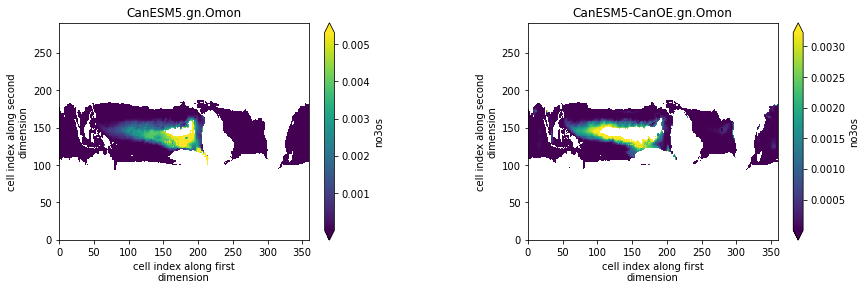

In [222]:
fig, axarr = plt.subplots(ncols=2, nrows=1, figsize=[14,4])
for ax, (name, ds) in zip(axarr.flat, ddict_combined.items()):
    # show just the first time step
    ds = ds.isel(time=0)
    
    # mask out the surface nitrate where the SST is above 25 deg
    da = ds.no3os.where(ds.tos>=25)
    
    # average all members
    if 'member_id' in da.dims:
        da = da.mean('member_id')
    da.plot(ax=ax, robust=True)
    ax.set_title(name)
fig.subplots_adjust(hspace=0.5, wspace=0.5)

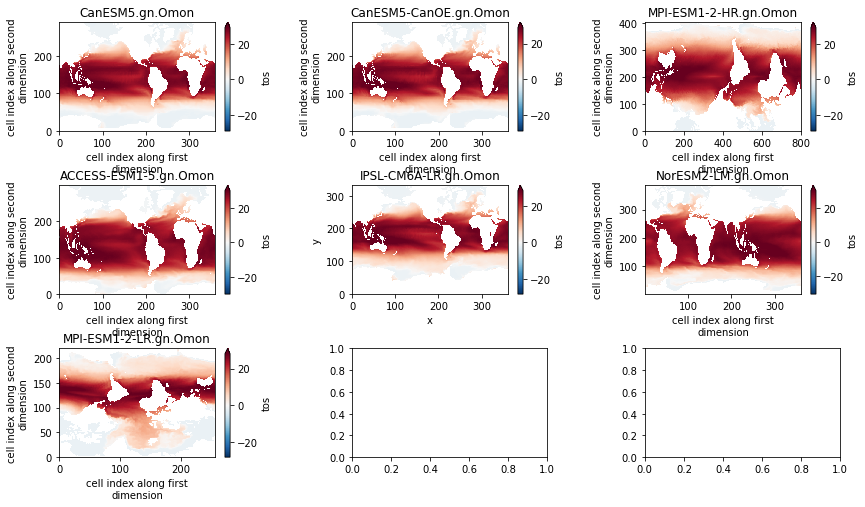

In [233]:
fig, axarr = plt.subplots(ncols=3, nrows=3, figsize=[14,8])
for ax, (name, ds) in zip(axarr.flat, ddict_combined.items()):
    # show just the first time step
    ds = ds.isel(time=0)
    
    # average all members
    if 'member_id' in ds.dims:
        ds = ds.mean('member_id')
    ds.tos.plot(ax=ax, robust=True)
    ax.set_title(name)
fig.subplots_adjust(hspace=0.5, wspace=0.5)

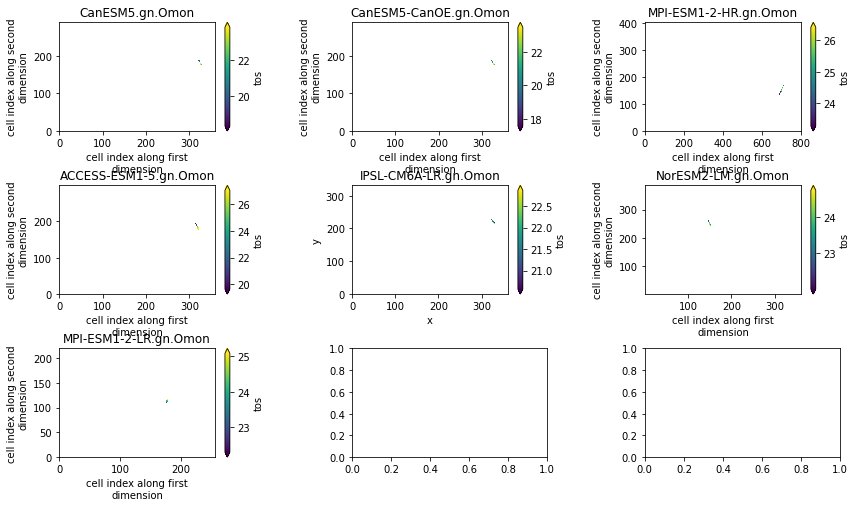

In [234]:
fig, axarr = plt.subplots(ncols=3, nrows=3, figsize=[14,8])
for ax, (name, ds) in zip(axarr.flat, ddict_combined.items()):
    # show just the first time step
    ds = ds.isel(time=0)

    # average all members
    if 'member_id' in ds.dims:
        ds = ds.mean('member_id')
        
    # mask out the indian ocean
    mask = merged_mask(basins, ds)
    
    ds_masked = ds.where(mask == 10) # Does anyone know which number the Arabian sea? (thought it's #53 was it isn't quite working..., maybe #10?)
    
    ds_masked.tos.plot(ax=ax, robust=True)
    ax.set_title(name)
fig.subplots_adjust(hspace=0.5, wspace=0.5)